In [1]:
from __future__ import unicode_literals
from textblob import TextBlob
import pandas as pd

In [2]:
wine = pd.read_csv('../tfm_folder/winemag-data_first150k.csv.zip',sep=",")
wine.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


In [3]:
wine.columns

Index([u'Unnamed: 0', u'country', u'description', u'designation', u'points',
       u'price', u'province', u'region_1', u'region_2', u'variety', u'winery'],
      dtype='object')

In [4]:
wine = wine.drop('Unnamed: 0',1)

In [5]:
wine = wine.drop_duplicates()

In [6]:
len(wine)

97851

In [7]:
# we will keep only varieties containing at least 10 descriptions
num_reviews = wine.groupby('variety').description.count().to_frame().reset_index()
num_reviews = num_reviews[num_reviews.description > 9]
frequent_varieties = num_reviews.variety.tolist()
wine_f = wine.loc[wine['variety'].isin(frequent_varieties)]

In [8]:
# first we must clean the text by removing punctuation symbols and setting all words 
# to lowercase letters
import string 

def remove_punctuation(review):
    pepe = review.translate(None, string.punctuation)
    return pepe

# removing punctuation from descriptions
wine['description'] = wine['description'].apply(remove_punctuation)
# converting to lowercase letters
wine['description'] = wine['description'].str.lower()

In [10]:
#function that assigns a redness-score based on a list of descriptions, counting words typical of red wines
def redness_score(descriptions):
    red_freq = []
    for review in descriptions:
        review = TextBlob(review.decode('unicode-escape'))
        n1 = review.words.count("cherry")
        n2 = review.words.count("berry")
        n3 = review.words.count("cherries")
        n4 = review.words.count("berries")
        n5 = review.words.count("red")
        n6 = review.words.count("raspberry")
        n7 = review.words.count("raspberries")
        n8 = review.words.count("blueberry")
        n9 = review.words.count("blueberries")
        n10 = review.words.count("blackberry")
        n11 = review.words.count("blackberries")
        total_red = n1+n2+n3+n4+n5+n6+n7+n8+n9+n10+n11
        red_freq.append(total_red)
    return float(sum(red_freq))/len(red_freq)

In [11]:
#same thing for white wines
def whiteness_score(descriptions):
    white_freq = []
    for review in descriptions:
        review = TextBlob(review.decode('unicode-escape'))
        n1 = review.words.count("lemon")
        n2 = review.words.count("lemons")
        n3 = review.words.count("lime")
        n4 = review.words.count("limes")
        n5 = review.words.count("peach")
        n6 = review.words.count("peaches")
        n7 = review.words.count("white")
        n8 = review.words.count("apricot")
        n9 = review.words.count("pear")
        n10 = review.words.count("apple")
        n11 = review.words.count("nectarine")
        n12 = review.words.count("orange")
        n13 = review.words.count("pineapple")
        total_white = n1+n2+n3+n4+n5+n6+n7+n8+n9+n10+n11+n12+n13
        white_freq.append(total_white)
    return float(sum(white_freq))/len(white_freq)

In [12]:
red_types = []
for variety in wine_f.variety.unique():
    df_variety = wine_f[wine_f.variety == variety]
    red = redness_score(df_variety.description)
    red_types.append((variety,red)) # a redness score is asigned to each variety

In [13]:
# putting it in dataframe format
color_classification =  pd.DataFrame.from_records(red_types,columns=["variety","redness_score"])

In [14]:
white_types = []
for variety in wine_f.variety.unique():
    df_variety = wine_f[wine_f.variety == variety]
    white = whiteness_score(df_variety.description)
    white_types.append((variety,white)) # a whiteness score is asigned to each variety

In [15]:
white = pd.DataFrame.from_records(white_types,columns=["variety","whiteness_score"])

In [16]:
# merging the two dataframes, we have a dataframe which, for each variety provides a redness and whiteness score
color_classification = color_classification.merge(white,how='left',on='variety')

In [17]:
color_classification.sample(5)

,variety,redness_score,whiteness_score
119,Petit Manseng,0.035714,1.250000
108,Port,0.328147,0.089109
95,Shiraz,1.039075,0.030303
47,Touriga Nacional,0.495798,0.000000
80,Semillon-Sauvignon Blanc,0.055556,1.388889


In [18]:
# a function that compares the redness and whiteness score for each variety,
# and returns "red" if redness score is greater, "white" if whiteness score
# is greater, or "inconclusive" otherwise
def identify_color(redness,whiteness):
    if redness > whiteness:
        return "red"
    if redness < whiteness:
        return "white"
    else:
        return "inconclusive"

In [19]:
import numpy as np

In [20]:
color_classification['color'] = np.vectorize(identify_color)(color_classification['redness_score'], color_classification['whiteness_score'])

In [21]:
color_classification.sample(9)

,variety,redness_score,whiteness_score,color
75,Vermentino,0.000000,1.289855,white
23,Nebbiolo,1.206871,0.183719,red
234,Pallagrello,0.166667,0.750000,white
220,Cabernet Merlot,0.703704,0.037037,red
145,Marsanne-Roussanne,0.000000,1.380952,white
116,Garnacha Blanca,0.000000,2.166667,white
144,Pedro Ximénez,0.000000,0.692308,white
108,Port,0.328147,0.089109,red
212,Pinotage,1.343284,0.029851,red


In [22]:
color_classification.color.value_counts()

red      129
white    121
Name: color, dtype: int64

In [23]:
reds = color_classification[color_classification.color == "red"]

In [24]:
reds["color_p"] = reds.redness_score-reds.whiteness_score

/Users/luis/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [26]:
#checking dubious cases of red wines (lowest difference between redness and whiteness scores)
reds.sort_values(by='color_p').head()

,variety,redness_score,whiteness_score,color,color_p
248,Madeira Blend,0.166667,0.083333,red,0.083333
108,Port,0.328147,0.089109,red,0.239038
134,Rosado,0.809524,0.523810,red,0.285714
66,Tannat-Cabernet,0.333333,0.000000,red,0.333333
178,Touriga Nacional Blend,0.454545,0.000000,red,0.454545


In [27]:
whites = color_classification[color_classification.color == "white"]

In [28]:
whites["color_p"] = whites.whiteness_score-whites.redness_score

/Users/luis/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [29]:
#checking the more dubious cases of white wines
whites.sort_values(by='color_p').head()

,variety,redness_score,whiteness_score,color,color_p
238,Tokay,0.000000,0.250000,white,0.250000
100,Portuguese Sparkling,0.206897,0.482759,white,0.275862
97,Champagne Blend,0.254007,0.573366,white,0.319359
151,Roter Veltliner,0.300000,0.700000,white,0.400000
136,Muskat Ottonel,0.153846,0.615385,white,0.461538


In [30]:
# including color column in descriptions dataframe by merging
wine_f = wine_f.merge(color_classification,how='left',on="variety")

In [34]:
# redefining dataframes with grape color included
wine_w = wine_f[wine_f.color=="white"]
wine_r = wine_f[wine_f.color=="red"]

In [35]:
# we add a new column termed "quality", if points > 90 the wine is high quality, else we consider it low quality
def rating_type(score):
    if score > 92:
        return 1
    if score <= 84:
        return 0
    if score>84 and score<=92:
        return 2

wine_f['quality'] = wine_f.points.apply(rating_type)
wine_r['quality'] = wine_r.points.apply(rating_type)
wine_w['quality'] = wine_w.points.apply(rating_type)

/Users/luis/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/luis/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [36]:
# eliminating medium quality wines from dataframe
wine_f = wine_f[wine_f.quality.isin([0,1])==True]
wine_w = wine_w[wine_w.quality.isin([0,1])==True]
wine_r = wine_r[wine_r.quality.isin([0,1])==True]

In [37]:
# removing punctuation from descriptions
wine_f['description'] = wine_f['description'].apply(remove_punctuation)
wine_r['description'] = wine_r['description'].apply(remove_punctuation)
wine_w['description'] = wine_w['description'].apply(remove_punctuation)

In [39]:
# converting to lowercase letters
wine_f['description'] = wine_f['description'].str.lower()
wine_w['description'] = wine_w['description'].str.lower()
wine_r['description'] = wine_r['description'].str.lower()

In [40]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [41]:
X= wine_f['description']
y = wine_f['quality'].values

In [42]:
vectorizer = CountVectorizer(min_df = 0.07, max_df=0.93,
                             ngram_range=(1,1), 
                             stop_words='english')

transformer = TfidfTransformer()

from sklearn.model_selection import train_test_split
X_train, X_test,y_train,y_test = train_test_split(X,y,test_size = 0.5,random_state = 42)

In [43]:
vectorizer.fit(X_train)

CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=0.93, max_features=None, min_df=0.07,
        ngram_range=(1, 1), preprocessor=None, stop_words=u'english',
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [46]:
vocab = vectorizer.get_feature_names() # bag of words that will be used as predictors for the classifier
vocab

[u'acidity',
 u'aromas',
 u'berry',
 u'black',
 u'blackberry',
 u'blend',
 u'cherry',
 u'drink',
 u'dry',
 u'finish',
 u'flavors',
 u'fruit',
 u'fruits',
 u'good',
 u'green',
 u'like',
 u'nose',
 u'notes',
 u'oak',
 u'palate',
 u'red',
 u'rich',
 u'ripe',
 u'shows',
 u'simple',
 u'soft',
 u'spice',
 u'sweet',
 u'tannins',
 u'vanilla',
 u'wine',
 u'years']

In [47]:
X_test = vectorizer.transform(X_test)
transformer.fit(X_test)
X_test = transformer.transform(X_test) # convert to tfidf

In [48]:
X_train = vectorizer.transform(X_train)
transformer.fit(X_train)
X_train = transformer.transform(X_train) # convert to tfidf 

In [49]:
from sklearn.naive_bayes import GaussianNB
clf_NB = GaussianNB()

In [50]:
clf_NB.fit(X_train.toarray(),y_train)

GaussianNB(priors=None)

In [51]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, confusion_matrix

In [53]:
print("accuracy",accuracy_score(clf_NB.predict(X_test.toarray()),y_test))
print("precission score",precision_score(clf_NB.predict(X_test.toarray()),y_test))
print("recall score",recall_score(clf_NB.predict(X_test.toarray()),y_test))
print(np.mean(cross_val_score(clf_NB,X_test.toarray(),y_test,cv=50))*100)
print(np.std(cross_val_score(clf_NB,X_test.toarray(),y_test,cv=50))*100)

(u'accuracy', 0.76333451077357828)
(u'precission score', 0.79869816779170688)
(u'recall score', 0.64230321830166737)
75.8644892337
2.25452744219


In [54]:
confusion_matrix(clf_NB.predict(X_test.toarray()),y_test)

array([[5331,  835],
       [1845, 3313]])

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline

(array([ 2.,  5.,  5.,  7.,  9.,  8.,  4.,  6.,  3.,  1.]),
 array([ 0.71238938,  0.72220771,  0.73202604,  0.74184437,  0.7516627 ,
         0.76148103,  0.77129936,  0.7811177 ,  0.79093603,  0.80075436,
         0.81057269]),
 <a list of 10 Patch objects>)

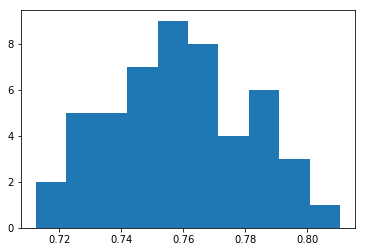

In [56]:
plt.hist(cross_val_score(clf_NB,X_test.toarray(),y_test,cv=50))

0.856650200927


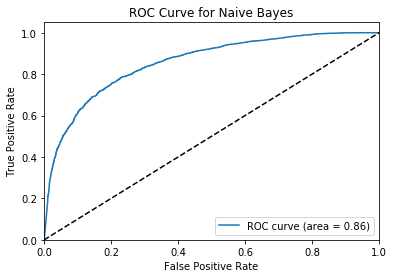

In [57]:
from sklearn.metrics import roc_curve, auc

clf_NB.fit(X_train.toarray(), y_train)
 
# Determine the false positive and true positive rates
fpr, tpr, _ = roc_curve(y_test, clf_NB.predict_proba(X_test.toarray())[:,1])
 
# Calculate the AUC
roc_auc = auc(fpr, tpr)
print(roc_auc)
 
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Naive Bayes')
plt.legend(loc="lower right")
plt.show()

In [58]:
# logistic regression for predicting wine quality

In [59]:
from sklearn.linear_model import LogisticRegression
clf_lr = LogisticRegression()

In [60]:
clf_lr.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [61]:
accuracy_score(clf_lr.predict(X_test),y_test)*100

82.170611091487118

In [62]:
precision_score(clf_lr.predict(X_test),y_test,pos_label=0)*100

90.273132664437014

In [63]:
recall_score(clf_lr.predict(X_test),y_test,pos_label=0)*100

83.061931016797033

In [65]:
dmat = confusion_matrix(clf_lr.predict(X_test.toarray()),y_test)

In [66]:
dmat

array([[6478, 1321],
       [ 698, 2827]])

0.878240117734


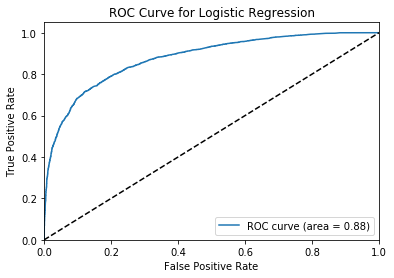

In [67]:
clf_lr.fit(X_train, y_train)
 
# Determine the false positive and true positive rates
fpr, tpr, _ = roc_curve(y_test, clf_lr.predict_proba(X_test)[:,1])
 
# Calculate the AUC
roc_auc = auc(fpr, tpr)
print(roc_auc)
 
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.legend(loc="lower right")
plt.show()

In [68]:
# Let us try our classifiers now on red wines only

In [69]:
X = wine_r['description']
y = wine_r['quality'].values

vectorizer = CountVectorizer(min_df = 0.07, max_df=0.93,
                             ngram_range=(1,1), 
                             stop_words='english')

transformer = TfidfTransformer()

from sklearn.model_selection import train_test_split
X_train, X_test,y_train,y_test = train_test_split(X,y,test_size = 0.5,random_state = 42)

In [71]:
vectorizer.fit(X_train)
vocab = vectorizer.get_feature_names()
vocab

[u'acidity',
 u'aromas',
 u'berry',
 u'black',
 u'blackberry',
 u'blend',
 u'cabernet',
 u'cherries',
 u'cherry',
 u'chocolate',
 u'dark',
 u'drink',
 u'dry',
 u'finish',
 u'flavors',
 u'fruit',
 u'good',
 u'like',
 u'nose',
 u'notes',
 u'oak',
 u'palate',
 u'plum',
 u'raspberry',
 u'red',
 u'rich',
 u'ripe',
 u'shows',
 u'simple',
 u'soft',
 u'spice',
 u'structure',
 u'sweet',
 u'tannic',
 u'tannins',
 u'wine',
 u'years']

In [72]:
X_test = vectorizer.transform(X_test)
transformer.fit(X_test)
X_test = transformer.transform(X_test) # convert to tfidf
X_train = vectorizer.transform(X_train)
transformer.fit(X_train)
X_train = transformer.transform(X_train) # convert to tfidf

In [73]:
clf_NB.fit(X_train.toarray(), y_train)

GaussianNB(priors=None)

In [74]:
print(accuracy_score(clf_NB.predict(X_test.toarray()),y_test))
print(precision_score(clf_NB.predict(X_test.toarray()),y_test))
print(recall_score(clf_NB.predict(X_test.toarray()),y_test))
print(np.mean(cross_val_score(clf_NB,X_test.toarray(),y_test,cv=50))*100)
print(np.std(cross_val_score(clf_NB,X_test.toarray(),y_test,cv=50))*100)

0.772396780057
0.819485174324
0.677167474421
76.6288216949
3.24985013293


In [75]:
confusion_matrix(clf_NB.predict(X_test.toarray()),y_test)

array([[3434,  554],
       [1199, 2515]])

0.867901317401


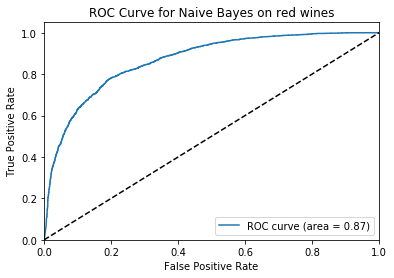

In [76]:
clf_NB.fit(X_train.toarray(), y_train)
 
# Determine the false positive and true positive rates
fpr, tpr, _ = roc_curve(y_test, clf_NB.predict_proba(X_test.toarray())[:,1])
 
# Calculate the AUC
roc_auc = auc(fpr, tpr)
print(roc_auc)
 
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Naive Bayes on red wines')
plt.legend(loc="lower right")
plt.show()

In [77]:
# logistic regression with red wines

In [78]:
clf_lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [79]:
print("accurary",accuracy_score(clf_lr.predict(X_test),y_test))
print("precision",precision_score(clf_lr.predict(X_test),y_test))
print("recall",recall_score(clf_lr.predict(X_test),y_test))
print("cross validation",np.mean(cross_val_score(clf_lr,X_test,y_test,cv=50))*100)
print(np.std(cross_val_score(clf_lr,X_test,y_test,cv=50))*100)

(u'accurary', 0.82537003375746565)
(u'precision', 0.73704789833822093)
(u'recall', 0.80785714285714283)
(u'cross validation', 82.551924777731216)
2.51264759943


In [80]:
confusion_matrix(clf_lr.predict(X_test),y_test)

array([[4095,  807],
       [ 538, 2262]])

0.900059513273


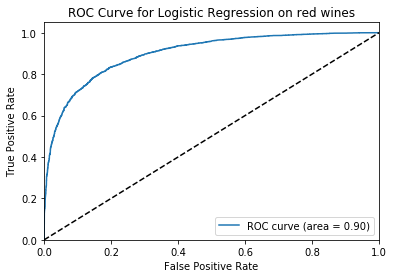

In [81]:
clf_lr.fit(X_train, y_train)
 
# Determine the false positive and true positive rates
fpr, tpr, _ = roc_curve(y_test, clf_lr.predict_proba(X_test)[:,1])
 
# Calculate the AUC
roc_auc = auc(fpr, tpr)
print(roc_auc)
 
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression on red wines')
plt.legend(loc="lower right")
plt.show()

In [82]:
#Let's try now only with white wines

In [83]:
X = wine_w['description']
y = wine_w['quality'].values

vectorizer = CountVectorizer(min_df = 0.07, max_df=0.93,
                             ngram_range=(1,1), 
                             stop_words='english')

transformer = TfidfTransformer()

from sklearn.model_selection import train_test_split
X_train, X_test,y_train,y_test = train_test_split(X,y,test_size = 0.5,random_state = 42)

In [85]:
vectorizer.fit(X_train)
vocab = vectorizer.get_feature_names()
vocab

[u'acidity',
 u'apple',
 u'apricot',
 u'aromas',
 u'character',
 u'chardonnay',
 u'citrus',
 u'clean',
 u'crisp',
 u'drink',
 u'dry',
 u'finish',
 u'flavors',
 u'fresh',
 u'fruit',
 u'fruits',
 u'good',
 u'green',
 u'honey',
 u'lemon',
 u'light',
 u'like',
 u'nose',
 u'notes',
 u'oak',
 u'orange',
 u'palate',
 u'peach',
 u'pear',
 u'pineapple',
 u'rich',
 u'ripe',
 u'shows',
 u'simple',
 u'soft',
 u'spice',
 u'sweet',
 u'tropical',
 u'vanilla',
 u'white',
 u'wine']

In [86]:
X_test = vectorizer.transform(X_test)
transformer.fit(X_test)
X_test = transformer.transform(X_test) # convert to tfidf
X_train = vectorizer.transform(X_train)
transformer.fit(X_train)
X_train = transformer.transform(X_train) # convert to tfidf

In [87]:
clf_NB.fit(X_train.toarray(), y_train)

GaussianNB(priors=None)

In [88]:
print(accuracy_score(clf_NB.predict(X_test.toarray()),y_test))
print(precision_score(clf_NB.predict(X_test.toarray()),y_test))
print(recall_score(clf_NB.predict(X_test.toarray()),y_test))
print(np.mean(cross_val_score(clf_NB,X_test.toarray(),y_test,cv=50))*100)
print(np.std(cross_val_score(clf_NB,X_test.toarray(),y_test,cv=50))*100)

0.761457758145
0.780969479354
0.58389261745
73.9292648813
5.07355928382


In [89]:
confusion_matrix(clf_NB.predict(X_test.toarray()),y_test)

array([[1888,  244],
       [ 620,  870]])

0.850972221029


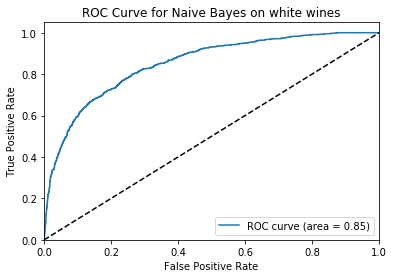

In [90]:
# Determine the false positive and true positive rates
fpr, tpr, _ = roc_curve(y_test, clf_NB.predict_proba(X_test.toarray())[:,1])
 
# Calculate the AUC
roc_auc = auc(fpr, tpr)
print(roc_auc)
 
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Naive Bayes on white wines')
plt.legend(loc="lower right")
plt.show()

In [91]:
# Logistic Regression on white wines

In [92]:
clf_lr.fit(X_train.toarray(), y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [93]:
print(accuracy_score(clf_lr.predict(X_test.toarray()),y_test))
print(precision_score(clf_lr.predict(X_test.toarray()),y_test))
print(recall_score(clf_lr.predict(X_test.toarray()),y_test))
print(np.mean(cross_val_score(clf_lr,X_test.toarray(),y_test,cv=50))*100)
print(np.std(cross_val_score(clf_lr,X_test.toarray(),y_test,cv=50))*100)

0.818608503589
0.587073608618
0.768507638073
81.9216339627
4.05515957541


In [94]:
confusion_matrix(clf_lr.predict(X_test.toarray()),y_test)

array([[2311,  460],
       [ 197,  654]])

0.871372469856


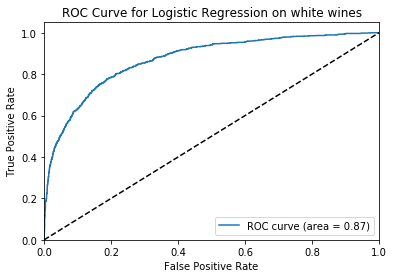

In [95]:
# Determine the false positive and true positive rates
fpr, tpr, _ = roc_curve(y_test, clf_lr.predict_proba(X_test.toarray())[:,1])
 
# Calculate the AUC
roc_auc = auc(fpr, tpr)
print(roc_auc)
 
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression on white wines')
plt.legend(loc="lower right")
plt.show()